In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from litdata import StreamingDataset
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Set up paths
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data" / "optimized"

print("=" * 80)
print("COMPREHENSIVE OPTIMIZED DATASET ANALYSIS")
print("=" * 80)

# Load normalization stats
stats_file = DATA_DIR / "normalization_stats.json"
with open(stats_file, "r") as f:
    norm_stats = json.load(f)

print(f"\n✓ Loaded normalization stats from: {stats_file.name}")
print(f"   Normalization method: {norm_stats['normalization_method']}")

# Load the datasets
train_dir = DATA_DIR / "train"
val_dir = DATA_DIR / "val"
test_dir = DATA_DIR / "test"

train_dataset = StreamingDataset(input_dir=str(train_dir))
val_dataset = StreamingDataset(input_dir=str(val_dir))
test_dataset = StreamingDataset(input_dir=str(test_dir))

print(f"\n📊 Dataset Statistics:")
print(f"   Training samples: {len(train_dataset):,}")
print(f"   Validation samples: {len(val_dataset):,}")
print(f"   Test samples: {len(test_dataset):,}")
print(f"   Total: {len(train_dataset) + len(val_dataset) + len(test_dataset):,}")
print("\n" + "=" * 80)

COMPREHENSIVE OPTIMIZED DATASET ANALYSIS

✓ Loaded normalization stats from: normalization_stats.json
   Normalization method: zscore

📊 Dataset Statistics:
   Training samples: 5,764
   Validation samples: 1,235
   Test samples: 1,236
   Total: 8,235



In [2]:
INPUT_FEATURES = norm_stats["input_features"]
MICROSTRUCTURE_FEATURES = norm_stats["microstructure_features"]
PERFORMANCE_FEATURES = norm_stats["performance_features"]

print(f"\n{'='*80}")
print(f"FEATURE DEFINITIONS")
print(f"{'='*80}\n")

print(f"Input Features ({len(INPUT_FEATURES)}):")
for i, feat in enumerate(INPUT_FEATURES, 1):
    print(f"   {i:2d}. {feat}")

print(f"\nMicrostructure Features ({len(MICROSTRUCTURE_FEATURES)}):")
for i, feat in enumerate(MICROSTRUCTURE_FEATURES, 1):
    print(f"   {i}. {feat}")

print(f"\nPerformance Features ({len(PERFORMANCE_FEATURES)}):")
for i, feat in enumerate(PERFORMANCE_FEATURES, 1):
    print(f"   {i}. {feat}")

print(f"\n{'='*80}")


FEATURE DEFINITIONS

Input Features (15):
    1. input_SEI kinetic rate constant [m.s-1]
    2. input_Electrolyte diffusivity [m2.s-1]
    3. input_Initial concentration in electrolyte [mol.m-3]
    4. input_Separator porosity
    5. input_Positive particle radius [m]
    6. input_Negative particle radius [m]
    7. input_Positive electrode thickness [m]
    8. input_Negative electrode thickness [m]
    9. input_Outer SEI solvent diffusivity [m2.s-1]
   10. input_Dead lithium decay constant [s-1]
   11. input_Lithium plating kinetic rate constant [m.s-1]
   12. input_Negative electrode LAM constant proportional term [s-1]
   13. input_Negative electrode cracking rate
   14. input_Outer SEI partial molar volume [m3.mol-1]
   15. input_SEI growth activation energy [J.mol-1]

Microstructure Features (4):
   1. D_eff
   2. porosity_measured
   3. tau_factor
   4. bruggeman_derived

Performance Features (5):
   1. projected_cycle_life
   2. capacity_fade_rate
   3. internal_resistance
   4

In [3]:
print(f"\n{'='*80}")
print(f"LOADING ALL SAMPLES FOR STATISTICAL ANALYSIS")
print(f"{'='*80}\n")


# Function to load all samples from a dataset
def load_all_samples(dataset, split_name):
    """Load all samples from a streaming dataset"""
    print(f"Loading {split_name} set ({len(dataset)} samples)...")

    all_input_params = []
    all_micro_outputs = []
    all_perf_outputs = []
    sample_ids = []
    param_ids = []

    for idx in range(len(dataset)):
        sample = dataset[idx]
        all_input_params.append(sample["input_params"])
        all_micro_outputs.append(sample["microstructure_outputs"])
        all_perf_outputs.append(sample["performance_outputs"])
        sample_ids.append(sample["sample_id"])
        param_ids.append(sample["param_id"])

        if (idx + 1) % 500 == 0:
            print(f"   Loaded {idx + 1}/{len(dataset)} samples...")

    return {
        "input_params": np.array(all_input_params),
        "microstructure_outputs": np.array(all_micro_outputs),
        "performance_outputs": np.array(all_perf_outputs),
        "sample_ids": np.array(sample_ids),
        "param_ids": np.array(param_ids),
    }


# Load all splits
train_data = load_all_samples(train_dataset, "train")
val_data = load_all_samples(val_dataset, "val")
test_data = load_all_samples(test_dataset, "test")

# Combine all for overall statistics
all_data = {
    "input_params": np.vstack(
        [
            train_data["input_params"],
            val_data["input_params"],
            test_data["input_params"],
        ]
    ),
    "microstructure_outputs": np.vstack(
        [
            train_data["microstructure_outputs"],
            val_data["microstructure_outputs"],
            test_data["microstructure_outputs"],
        ]
    ),
    "performance_outputs": np.vstack(
        [
            train_data["performance_outputs"],
            val_data["performance_outputs"],
            test_data["performance_outputs"],
        ]
    ),
    "sample_ids": np.concatenate(
        [train_data["sample_ids"], val_data["sample_ids"], test_data["sample_ids"]]
    ),
    "param_ids": np.concatenate(
        [train_data["param_ids"], val_data["param_ids"], test_data["param_ids"]]
    ),
}

print(f"\n✓ All data loaded:")
print(f"   Total samples: {len(all_data['sample_ids']):,}")
print(f"   Unique samples: {len(np.unique(all_data['sample_ids']))}")
print(f"   Unique params: {len(np.unique(all_data['param_ids']))}")


LOADING ALL SAMPLES FOR STATISTICAL ANALYSIS

Loading train set (5764 samples)...
   Loaded 500/5764 samples...
   Loaded 1000/5764 samples...
   Loaded 1500/5764 samples...
   Loaded 2000/5764 samples...
   Loaded 2500/5764 samples...
   Loaded 3000/5764 samples...
   Loaded 3500/5764 samples...
   Loaded 4000/5764 samples...
   Loaded 4500/5764 samples...
   Loaded 5000/5764 samples...
   Loaded 5500/5764 samples...
Loading val set (1235 samples)...
   Loaded 500/1235 samples...
   Loaded 1000/1235 samples...
Loading test set (1236 samples)...
   Loaded 500/1236 samples...
   Loaded 1000/1236 samples...

✓ All data loaded:
   Total samples: 8,235
   Unique samples: 85
   Unique params: 100


In [4]:
# Denormalization functions
def denormalize_zscore(normalized, stats):
    """Denormalize z-score normalized data"""
    mean = np.array(stats["mean"])
    std = np.array(stats["std"])
    std = np.where(std < 1e-8, 1.0, std)
    return (normalized * std) + mean


def denormalize_minmax(normalized, stats):
    """Denormalize min-max normalized data"""
    min_vals = np.array(stats["min"])
    ranges = np.array(stats["range"])
    return (normalized * ranges) + min_vals


def denormalize_features(normalized, stats):
    """Denormalize features based on method"""
    method = stats.get("method", "zscore")
    if method == "zscore":
        return denormalize_zscore(normalized, stats)
    elif method == "minmax":
        return denormalize_minmax(normalized, stats)
    else:
        raise ValueError(f"Unknown normalization method: {method}")


# Denormalize all data
print("Denormalizing data...")

input_denorm = denormalize_features(
    all_data["input_params"], norm_stats["input_params"]
)
micro_denorm = denormalize_features(
    all_data["microstructure_outputs"], norm_stats["microstructure_outputs"]
)
perf_denorm = denormalize_features(
    all_data["performance_outputs"], norm_stats["performance_outputs"]
)

# Create DataFrames
df_inputs = pd.DataFrame(input_denorm, columns=INPUT_FEATURES)
df_micro = pd.DataFrame(micro_denorm, columns=MICROSTRUCTURE_FEATURES)
df_perf = pd.DataFrame(perf_denorm, columns=PERFORMANCE_FEATURES)

# Add IDs
df_expanded = pd.concat(
    [
        pd.DataFrame(
            {
                "sample_id": all_data["sample_ids"],
                "param_id": all_data["param_ids"],
            }
        ),
        df_inputs,
        df_micro,
        df_perf,
    ],
    axis=1,
)

print(f"✓ Denormalized dataset shape: {df_expanded.shape}")
print(f"   Columns: {len(df_expanded.columns)}")

Denormalizing data...
✓ Denormalized dataset shape: (8235, 26)
   Columns: 26


In [5]:
# %%
print(f"\n{'='*80}")
print(f"INPUT FEATURES STATISTICS (DENORMALIZED)")
print(f"{'='*80}\n")

input_stats = df_inputs.describe().T
input_stats["missing"] = df_inputs.isnull().sum()
input_stats["missing_pct"] = (input_stats["missing"] / len(df_inputs) * 100).round(2)

cols = [
    "count",
    "mean",
    "std",
    "min",
    "25%",
    "50%",
    "75%",
    "max",
    "missing",
    "missing_pct",
]
input_stats = input_stats[cols]

print(input_stats.to_string())

missing_features = input_stats[input_stats["missing"] > 0]
constant_features = input_stats[input_stats["std"] == 0]

print("\nMissing features:")
print(
    missing_features[["missing", "missing_pct"]]
    if len(missing_features)
    else "   ✓ None"
)

print("\nConstant features:")
print(constant_features[["mean"]] if len(constant_features) else "   ✓ None")


INPUT FEATURES STATISTICS (DENORMALIZED)

                                                                count          mean           std           min           25%           50%           75%           max  missing  missing_pct
input_SEI kinetic rate constant [m.s-1]                        8235.0  4.809550e-14  3.974297e-14  1.000000e-14  1.000000e-14  2.970000e-14  1.000000e-13  1.000000e-13        0          0.0
input_Electrolyte diffusivity [m2.s-1]                         8235.0  3.018600e-10  5.834427e-11  2.000000e-10  2.520000e-10  3.060000e-10  3.540000e-10  3.980000e-10        0          0.0
input_Initial concentration in electrolyte [mol.m-3]           8235.0  1.000000e+03  0.000000e+00  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03        0          0.0
input_Separator porosity                                       8235.0  5.848634e-01  2.802273e-02  5.380924e-01  5.587958e-01  5.823130e-01  6.076321e-01  6.363797e-01        0          0.0
input_P

In [7]:
print(f"\n{'='*80}")
print(f"MICROSTRUCTURE FEATURES STATISTICS (DENORMALIZED)")
print(f"{'='*80}\n")

micro_stats = df_micro.describe().T
micro_stats["missing"] = df_micro.isnull().sum()
micro_stats["missing_pct"] = (micro_stats["missing"] / len(df_micro) * 100).round(2)
micro_stats = micro_stats[cols]

print(micro_stats.to_string())


MICROSTRUCTURE FEATURES STATISTICS (DENORMALIZED)

                    count      mean       std       min       25%       50%       75%       max  missing  missing_pct
D_eff              8235.0  0.186293  0.076387  0.044254  0.125497  0.174813  0.246265  0.365708        0          0.0
porosity_measured  8235.0  0.495234  0.067839  0.333288  0.441679  0.488890  0.544718  0.652044        0          0.0
tau_factor         8235.0  3.091986  1.212457  1.553926  2.310864  2.805653  3.598821  7.531231        0          0.0
bruggeman_derived  8235.0  1.599370  0.005769  1.546536  1.600000  1.600000  1.600000  1.600000        0          0.0


In [8]:
print(f"\n{'='*80}")
print(f"PERFORMANCE FEATURES STATISTICS (DENORMALIZED)")
print(f"{'='*80}\n")

perf_stats = df_perf.describe().T
perf_stats["missing"] = df_perf.isnull().sum()
perf_stats["missing_pct"] = (perf_stats["missing"] / len(df_perf) * 100).round(2)
perf_stats = perf_stats[cols]

print(perf_stats.to_string())

print(f"\n{'-'*80}")
print("DETAILED PERFORMANCE METRICS")
print(f"{'-'*80}")

for feat in PERFORMANCE_FEATURES:
    data = df_perf[feat].dropna()
    if len(data) > 0:
        print(f"\n{feat}:")
        print(f"   Count: {len(data):,}")
        print(f"   Mean: {data.mean():.4f}")
        print(f"   Std: {data.std():.4f}")
        print(f"   Min: {data.min():.4f}")
        print(f"   Max: {data.max():.4f}")


PERFORMANCE FEATURES STATISTICS (DENORMALIZED)

                       count       mean        std        min        25%        50%        75%        max  missing  missing_pct
projected_cycle_life  8235.0  42.184335  19.676909  12.999999  24.000000  36.000000  62.000002  78.000001        0          0.0
capacity_fade_rate    8235.0   0.027198   0.012895   0.007221   0.015906   0.024823   0.036370   0.064081        0          0.0
internal_resistance   8235.0   0.101446   0.004313   0.088297   0.098036   0.101470   0.104587   0.111489        0          0.0
nominal_capacity      8235.0   5.295704   0.873085   2.963431   4.648703   5.287941   5.950251   7.853955        0          0.0
energy_density        8235.0   3.883960   0.026755   3.806731   3.865069   3.883158   3.901776   3.970753        0          0.0

--------------------------------------------------------------------------------
DETAILED PERFORMANCE METRICS
------------------------------------------------------------------------

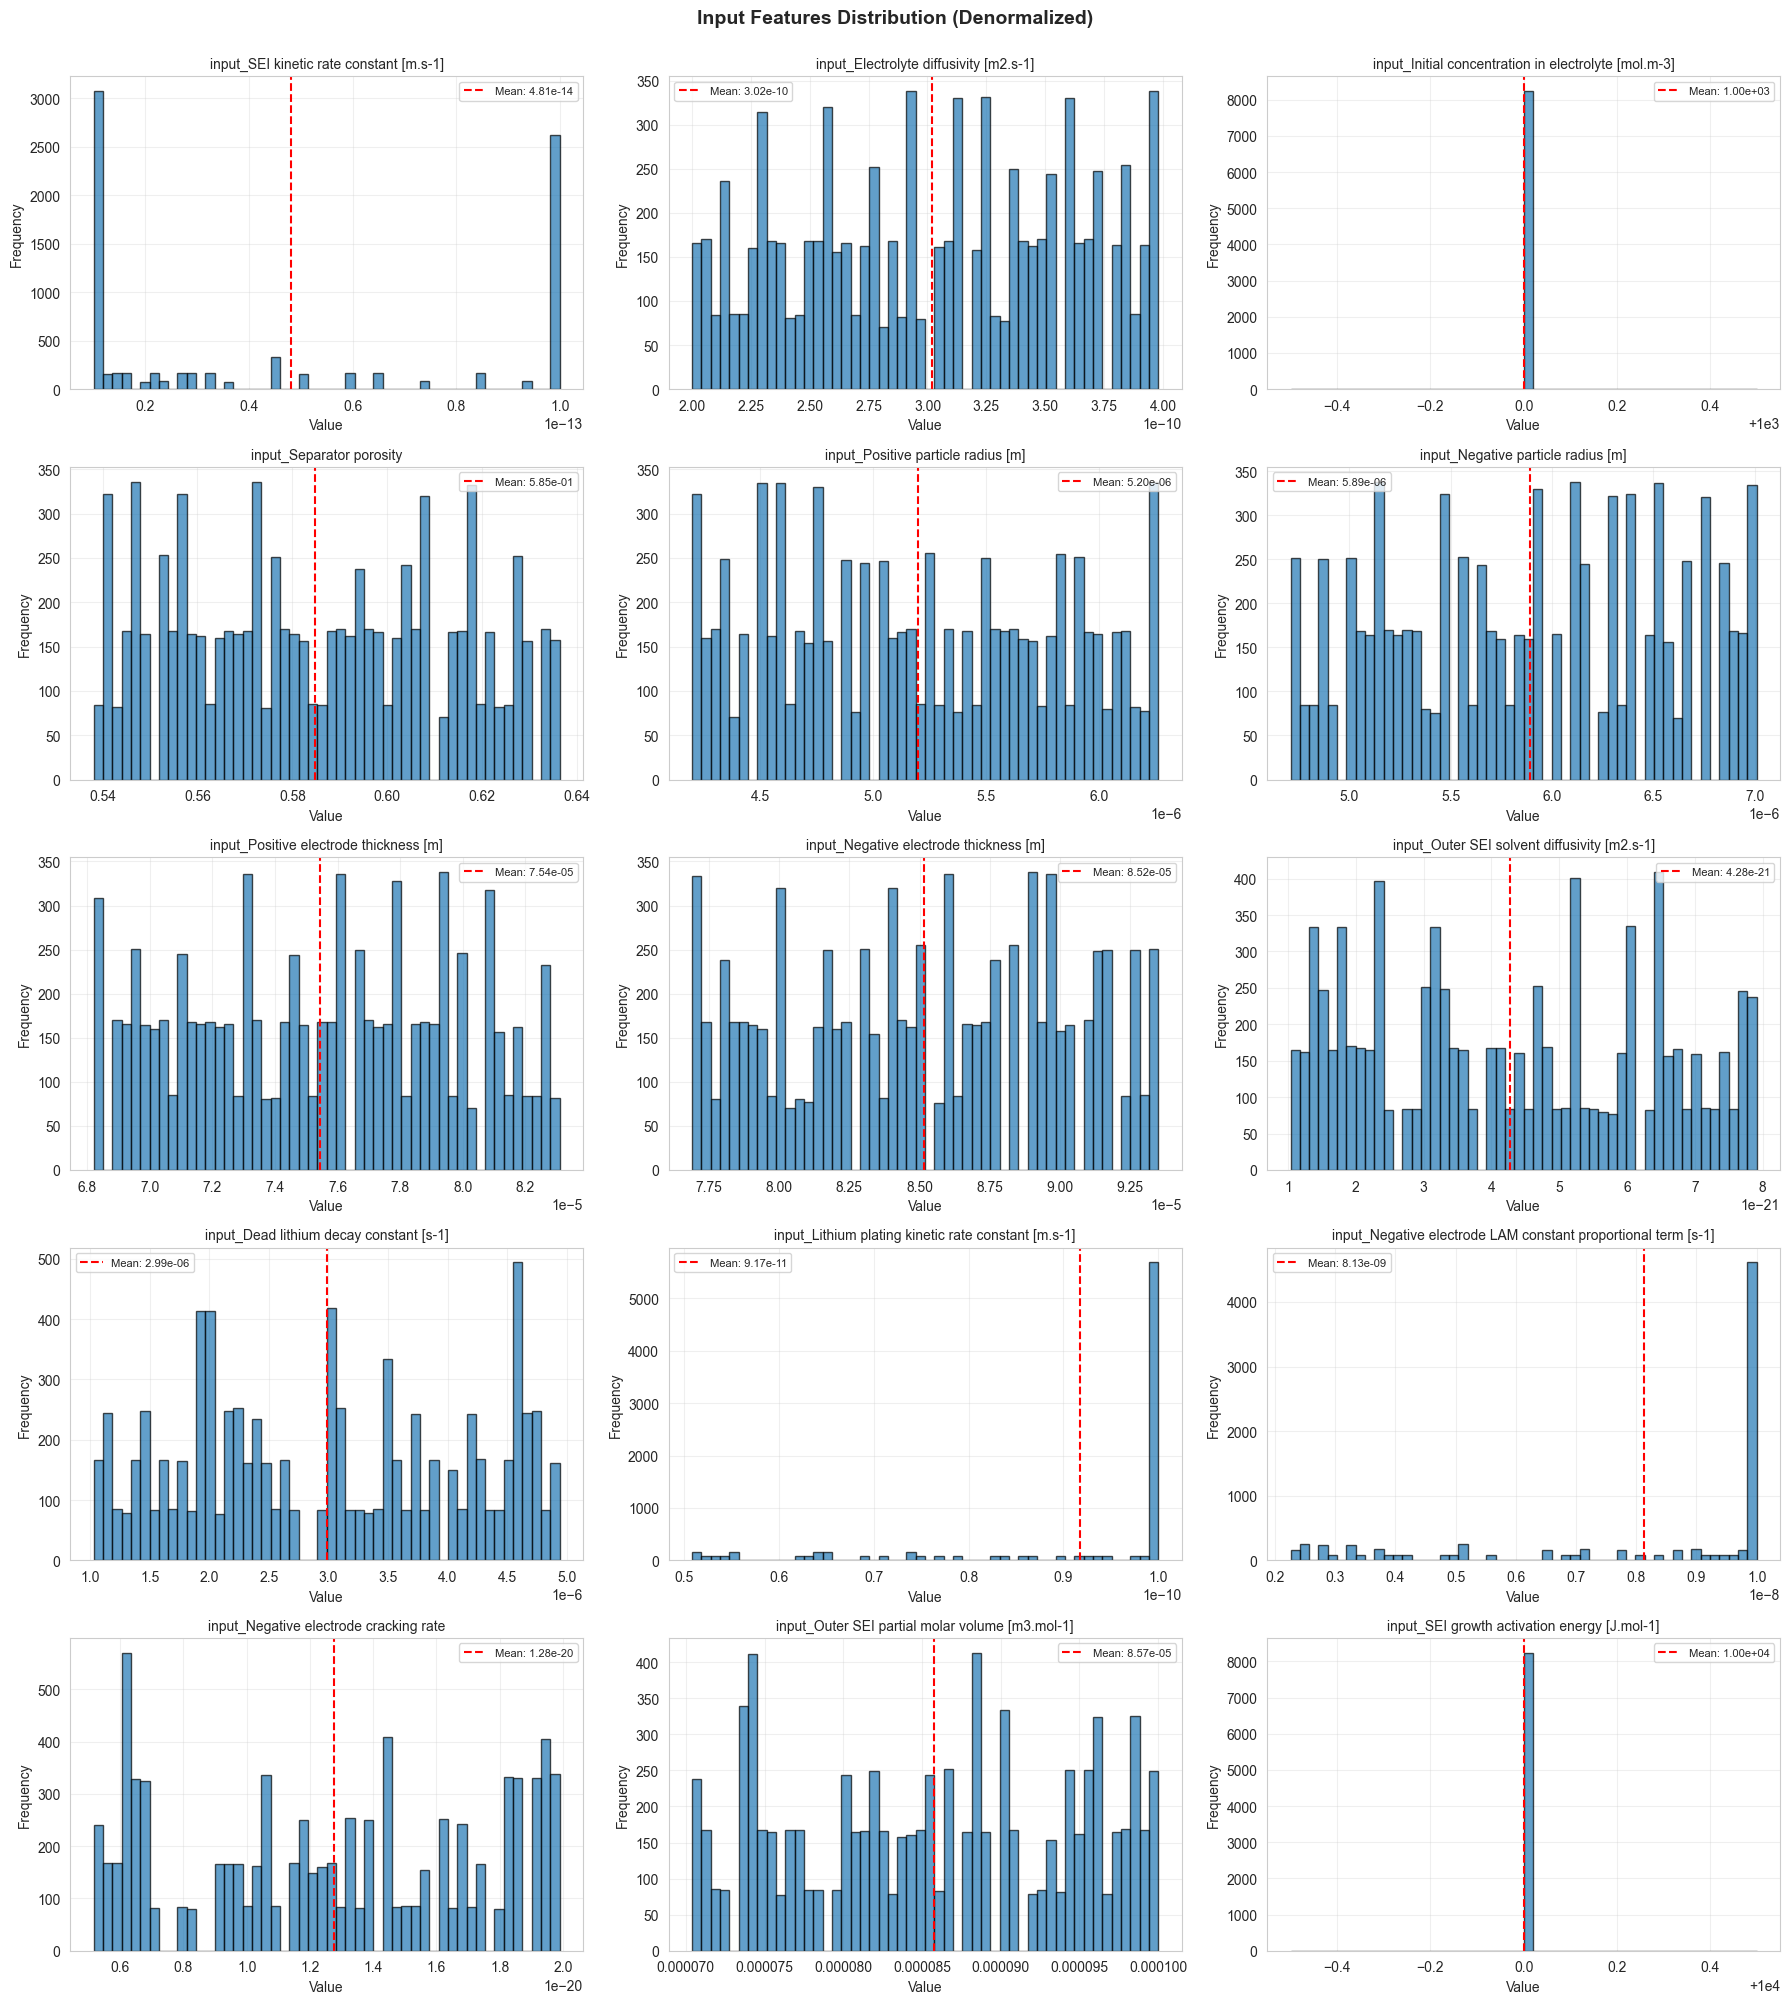

In [9]:
n_features = len(INPUT_FEATURES)
ncols = 3
nrows = (n_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
    ax.axvline(
        data.mean(), linestyle="--", color="red", label=f"Mean: {data.mean():.2e}"
    )
    ax.set_title(feat, fontsize=10)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.suptitle(
    "Input Features Distribution (Denormalized)", fontsize=14, fontweight="bold", y=1.00
)
plt.tight_layout()
plt.show()

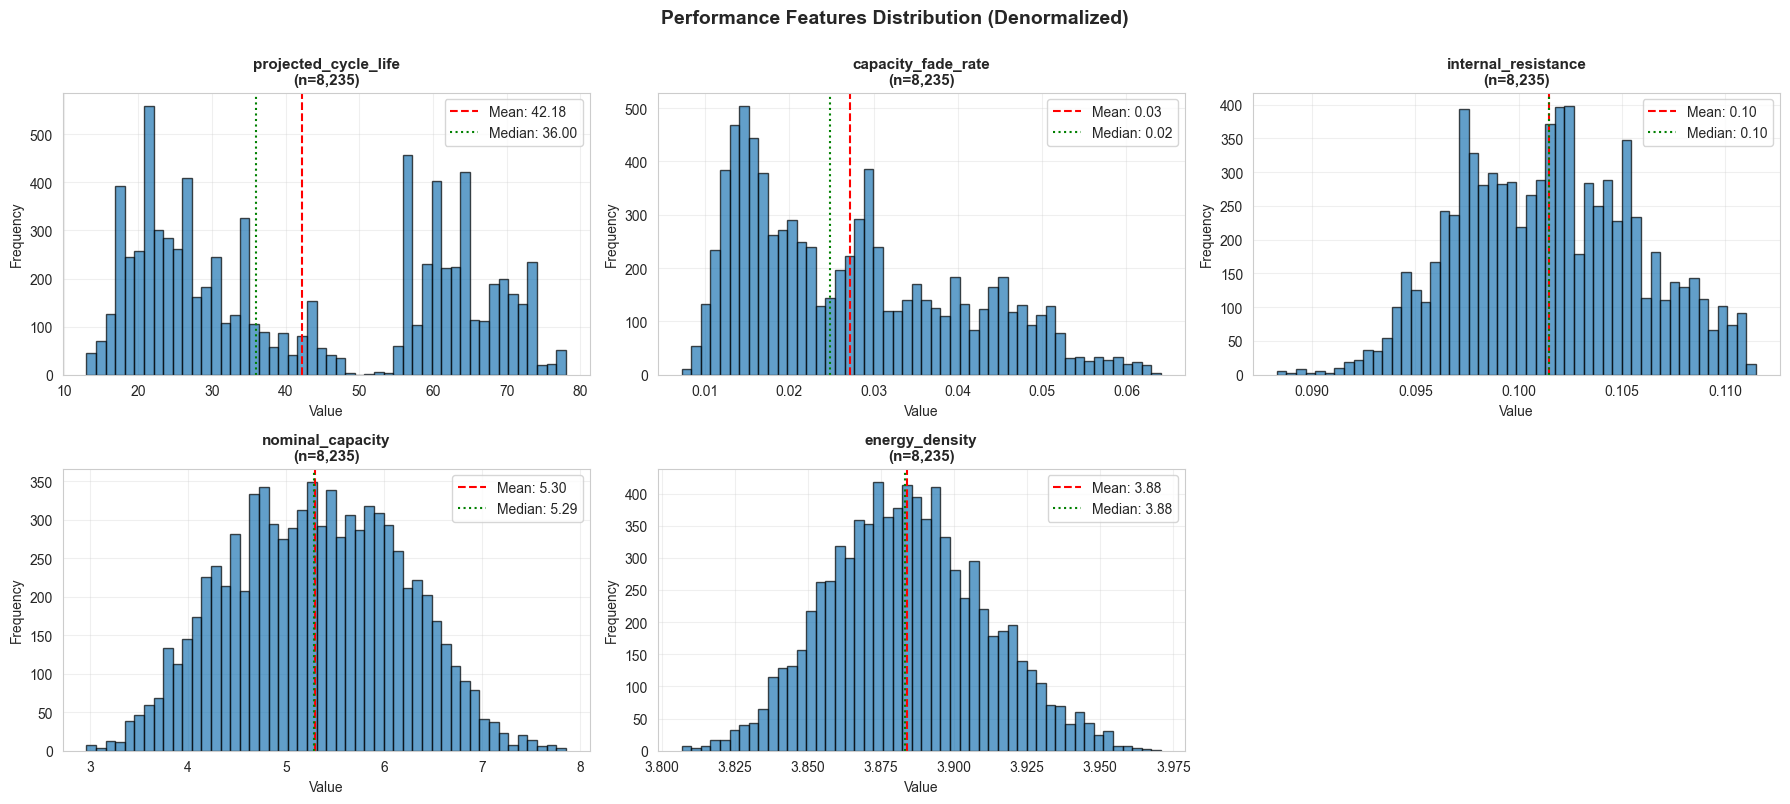

In [10]:
n_perf = len(PERFORMANCE_FEATURES)
ncols = 3
nrows = (n_perf + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
axes = axes.flatten()

for idx, feat in enumerate(PERFORMANCE_FEATURES):
    data = df_perf[feat].dropna()
    ax = axes[idx]

    if len(data) > 0:
        ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
        ax.axvline(
            data.mean(), linestyle="--", color="red", label=f"Mean: {data.mean():.2f}"
        )
        ax.axvline(
            data.median(),
            linestyle=":",
            color="green",
            label=f"Median: {data.median():.2f}",
        )
        ax.set_title(f"{feat}\n(n={len(data):,})", fontsize=11, fontweight="bold")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.3)
        ax.legend()

for idx in range(n_perf, len(axes)):
    axes[idx].axis("off")

plt.suptitle(
    "Performance Features Distribution (Denormalized)",
    fontsize=14,
    fontweight="bold",
    y=1.00,
)
plt.tight_layout()
plt.show()


🔬 SAMPLE VISUALIZATION - Sample 5099, Param 22

Image Information:
   Shape: (128, 128, 128)
   Dtype: float32
   Value range: [0.000, 1.000]
   Porosity (fraction of 0s): 45.80%
   Solid (fraction of 1s): 54.20%


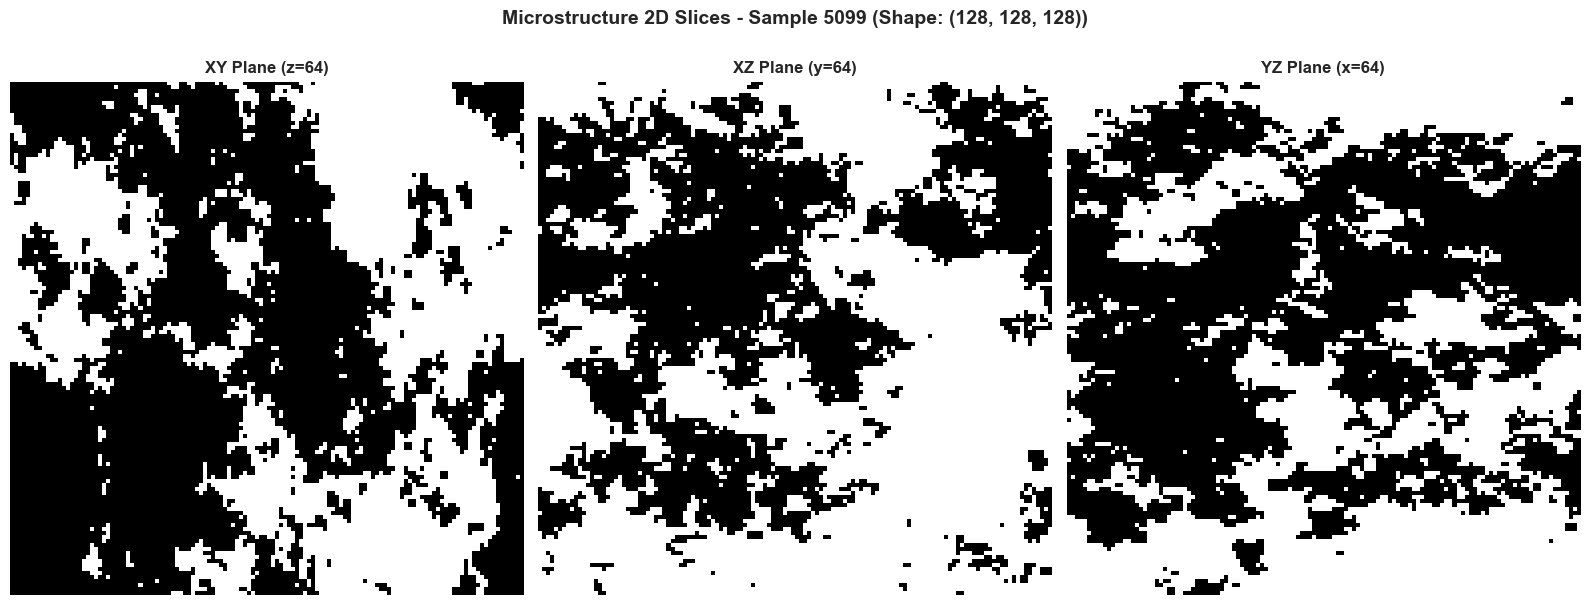

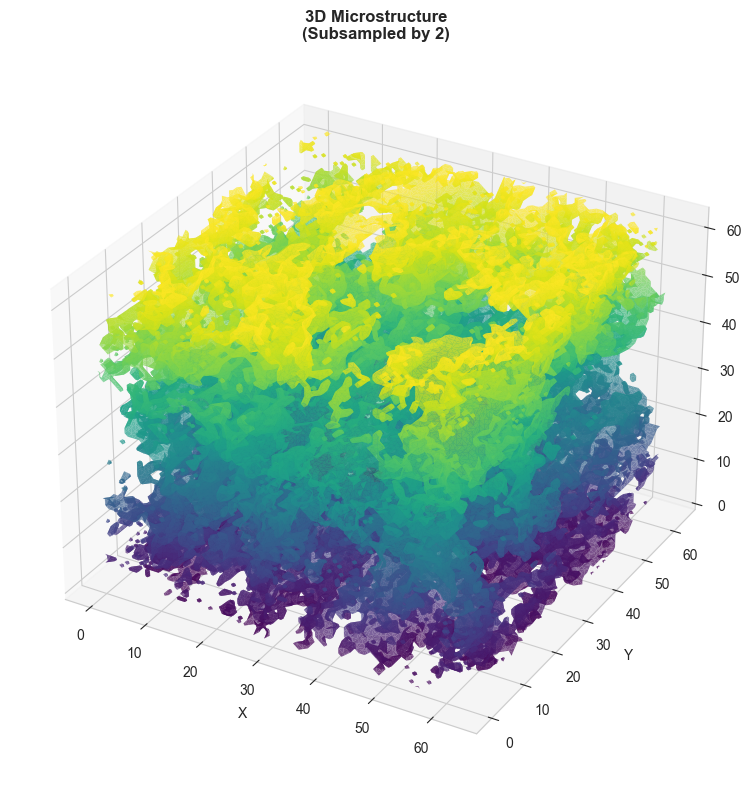

In [11]:
# Load a specific sample for visualization
sample_idx = 0  # Change this to view different samples
sample = train_dataset[sample_idx]

image = sample["image"]
sample_id = sample["sample_id"]
param_id = sample["param_id"]

print(f"\n{'='*80}")
print(f"🔬 SAMPLE VISUALIZATION - Sample {sample_id}, Param {param_id}")
print(f"{'='*80}\n")

print(f"Image Information:")
print(f"   Shape: {image.shape}")
print(f"   Dtype: {image.dtype}")
print(f"   Value range: [{image.min():.3f}, {image.max():.3f}]")
print(f"   Porosity (fraction of 0s): {(image == 0).sum() / image.size * 100:.2f}%")
print(f"   Solid (fraction of 1s): {(image == 1).sum() / image.size * 100:.2f}%")

# Create figure with 2D slices
fig = plt.figure(figsize=(16, 6))

mid_z = image.shape[0] // 2
mid_y = image.shape[1] // 2
mid_x = image.shape[2] // 2

# XY plane
ax1 = fig.add_subplot(131)
ax1.imshow(image[mid_z, :, :], cmap="gray", interpolation="nearest")
ax1.set_title(f"XY Plane (z={mid_z})", fontsize=12, fontweight="bold")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.axis("off")

# XZ plane
ax2 = fig.add_subplot(132)
ax2.imshow(image[:, mid_y, :], cmap="gray", interpolation="nearest")
ax2.set_title(f"XZ Plane (y={mid_y})", fontsize=12, fontweight="bold")
ax2.set_xlabel("X")
ax2.set_ylabel("Z")
ax2.axis("off")

# YZ plane
ax3 = fig.add_subplot(133)
ax3.imshow(image[:, :, mid_x], cmap="gray", interpolation="nearest")
ax3.set_title(f"YZ Plane (x={mid_x})", fontsize=12, fontweight="bold")
ax3.set_xlabel("Y")
ax3.set_ylabel("Z")
ax3.axis("off")

plt.suptitle(
    f"Microstructure 2D Slices - Sample {sample_id} (Shape: {image.shape})",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

# 3D visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

subsample_factor = max(1, image.shape[0] // 50)
subsampled = image[::subsample_factor, ::subsample_factor, ::subsample_factor]

try:
    threshold = subsampled.mean()
    verts, faces, _, _ = measure.marching_cubes(subsampled, threshold)

    ax.plot_trisurf(
        verts[:, 0],
        verts[:, 1],
        faces,
        verts[:, 2],
        cmap="viridis",
        alpha=0.7,
        linewidth=0,
        antialiased=True,
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(
        f"3D Microstructure\n(Subsampled by {subsample_factor})",
        fontsize=12,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"3D isosurface failed: {e}")
    threshold = subsampled.mean()
    z, y, x = np.where(subsampled > threshold)
    ax.scatter(x, y, z, c=subsampled[z, y, x], cmap="viridis", alpha=0.5, s=1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(
        f"3D Microstructure (Scatter)\n(Subsampled by {subsample_factor})",
        fontsize=12,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()

In [12]:
# Denormalize sample features
input_params_denorm = denormalize_features(
    sample["input_params"], norm_stats["input_params"]
)
micro_outputs_denorm = denormalize_features(
    sample["microstructure_outputs"], norm_stats["microstructure_outputs"]
)
perf_outputs_denorm = denormalize_features(
    sample["performance_outputs"], norm_stats["performance_outputs"]
)

print(f"\n{'='*80}")
print(f"COMPLETE DATA FOR SAMPLE {sample['sample_id']} | PARAM {sample['param_id']}")
print(f"{'='*80}\n")

# Input Parameters
print("INPUT PARAMETERS:")
print("-" * 80)
input_df = pd.DataFrame(
    {
        "Feature": INPUT_FEATURES,
        "Normalized": sample["input_params"],
        "Original Value": input_params_denorm,
    }
)
for col in ["Normalized", "Original Value"]:
    input_df[col] = input_df[col].apply(lambda x: f"{x:.6e}")
print(input_df.to_string(index=False))

# Microstructure
print(f"\n{'-'*80}")
print("MICROSTRUCTURE OUTPUTS:")
print("-" * 80)
micro_df = pd.DataFrame(
    {
        "Feature": MICROSTRUCTURE_FEATURES,
        "Normalized": sample["microstructure_outputs"],
        "Original Value": micro_outputs_denorm,
    }
)
for col in ["Normalized", "Original Value"]:
    micro_df[col] = micro_df[col].apply(lambda x: f"{x:.6f}")
print(micro_df.to_string(index=False))

# Performance
print(f"\n{'-'*80}")
print("PERFORMANCE OUTPUTS:")
print("-" * 80)
perf_df = pd.DataFrame(
    {
        "Feature": PERFORMANCE_FEATURES,
        "Normalized": sample["performance_outputs"],
        "Original Value": perf_outputs_denorm,
    }
)
for col in ["Normalized", "Original Value"]:
    perf_df[col] = perf_df[col].apply(lambda x: f"{x:.6f}")
print(perf_df.to_string(index=False))


COMPLETE DATA FOR SAMPLE 5099 | PARAM 22

INPUT PARAMETERS:
--------------------------------------------------------------------------------
                                                      Feature    Normalized Original Value
                      input_SEI kinetic rate constant [m.s-1]  5.221117e-14   1.000000e-13
                       input_Electrolyte diffusivity [m2.s-1] -1.018876e-10   2.000000e-10
         input_Initial concentration in electrolyte [mol.m-3]  0.000000e+00   1.000000e+03
                                     input_Separator porosity  1.324886e+00   6.219182e-01
                           input_Positive particle radius [m]  1.440222e+00   6.080000e-06
                           input_Negative particle radius [m]  4.671580e-02   5.930000e-06
                       input_Positive electrode thickness [m] -8.795136e-01   7.170000e-05
                       input_Negative electrode thickness [m]  1.339988e+00   9.170000e-05
                 input_Outer SEI solven

In [13]:
# %%
print(f"\n{'='*80}")
print(f"OPTIMIZED DATASET SUMMARY REPORT")
print(f"{'='*80}\n")

print("Dataset Splits:")
print(f"   Training: {len(train_dataset):,} samples")
print(f"   Validation: {len(val_dataset):,} samples")
print(f"   Test: {len(test_dataset):,} samples")
print(f"   Total: {len(all_data['sample_ids']):,} samples")

print(f"\nUnique Entities:")
print(f"   Unique samples: {len(np.unique(all_data['sample_ids']))}")
print(f"   Unique params: {len(np.unique(all_data['param_ids']))}")

print(f"\nFeature Counts:")
print(f"   Input features: {len(INPUT_FEATURES)}")
print(f"   Microstructure features: {len(MICROSTRUCTURE_FEATURES)}")
print(f"   Performance features: {len(PERFORMANCE_FEATURES)}")

print(f"\nNormalization:")
print(f"   Method: {norm_stats['normalization_method']}")

print(f"\nData Quality:")
print(f"   Input features - NaN: {df_inputs.isnull().sum().sum():,}")
print(f"   Microstructure features - NaN: {df_micro.isnull().sum().sum():,}")
print(f"   Performance features - NaN: {df_perf.isnull().sum().sum():,}")

print(f"\n{'='*80}")
print(f"✅ ANALYSIS COMPLETE!")
print(f"{'='*80}")


OPTIMIZED DATASET SUMMARY REPORT

Dataset Splits:
   Training: 5,764 samples
   Validation: 1,235 samples
   Test: 1,236 samples
   Total: 8,235 samples

Unique Entities:
   Unique samples: 85
   Unique params: 100

Feature Counts:
   Input features: 15
   Microstructure features: 4
   Performance features: 5

Normalization:
   Method: zscore

Data Quality:
   Input features - NaN: 0
   Microstructure features - NaN: 0
   Performance features - NaN: 0

✅ ANALYSIS COMPLETE!
